In [1]:
%pylab inline
import pandas as pd
#import xgboost
import lightgbm
import numpy
from scipy.sparse import csr_matrix

from sklearn.model_selection import train_test_split


import seaborn as sns
sns.set_style("whitegrid")

Populating the interactive namespace from numpy and matplotlib


In [2]:
df_train_variant = pd.read_csv("training_variants").set_index("ID")
df_train_text = pd.read_csv("training_text", delimiter = "\|\|", skiprows=1, names=['ID', 'Text'], engine="python").set_index('ID')

df_test_variant = pd.read_csv("test_variants").set_index("ID")
df_test_text = pd.read_csv("test_text", delimiter = "\|\|", skiprows = 1, names=["ID", "Text"], engine="python").set_index("ID")

In [3]:
df_train = pd.concat([df_train_variant, df_train_text ], axis=1)
df_test = pd.concat([df_test_variant, df_test_text], axis=1)

In [4]:
display(df_train.head())
display(df_test.head())

,Gene,Variation,Class,Text
ID,,,,
0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


,Gene,Variation,Text
ID,,,
0,ACSL4,R570S,2. This mutation resulted in a myeloproliferat...
1,NAGLU,P521L,Abstract The Large Tumor Suppressor 1 (LATS1)...
2,PAH,L333F,Vascular endothelial growth factor receptor (V...
3,ING1,A148D,Inflammatory myofibroblastic tumor (IMT) is a ...
4,TMEM216,G77A,Abstract Retinoblastoma is a pediatric retina...


In [5]:
print(df_train["Gene"].value_counts()[:10])
print(df_train["Class"].value_counts())

print(df_test["Gene"].value_counts()[:10])

BRCA1     264
TP53      163
EGFR      141
PTEN      126
BRCA2     125
KIT        99
BRAF       93
ALK        69
ERBB2      69
PDGFRA     60
Name: Gene, dtype: int64
7    953
4    686
1    568
2    452
6    275
5    242
3     89
9     37
8     19
Name: Class, dtype: int64
F8      134
CFTR     57
F9       54
G6PD     46
GBA      39
AR       38
PAH      38
CASR     37
ARSA     30
VWF      29
Name: Gene, dtype: int64


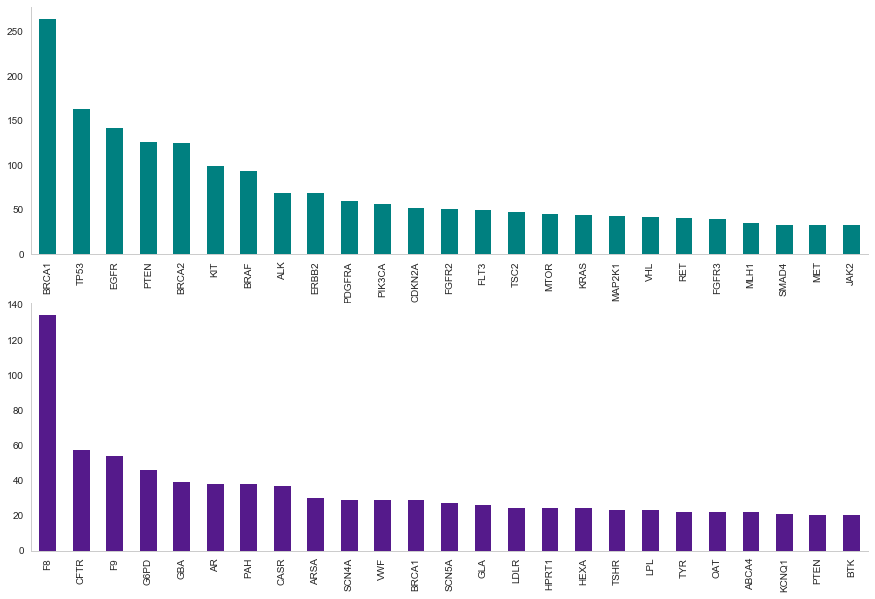

In [6]:
most_common_train = df_train["Gene"].value_counts()[:25] 
most_common_genes = most_common_train.index
df_train_most_common = df_train[df_train["Gene"].isin(most_common_genes)]
df_train_most_common_counts = df_train_most_common["Gene"].value_counts()

most_common_test = df_test["Gene"].value_counts()[:25] 
most_common_genes = most_common_test.index
df_test_most_common = df_test[df_test["Gene"].isin(most_common_genes)]
df_test_most_common_counts = df_test_most_common["Gene"].value_counts()

plt.figure(figsize=(15,10))
ax = plt.subplot(211)
df_train_most_common_counts.plot("bar", color="teal")
plt.grid(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax = plt.subplot(212)
df_test_most_common_counts.plot("bar", color="#551a8b")
plt.grid(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)


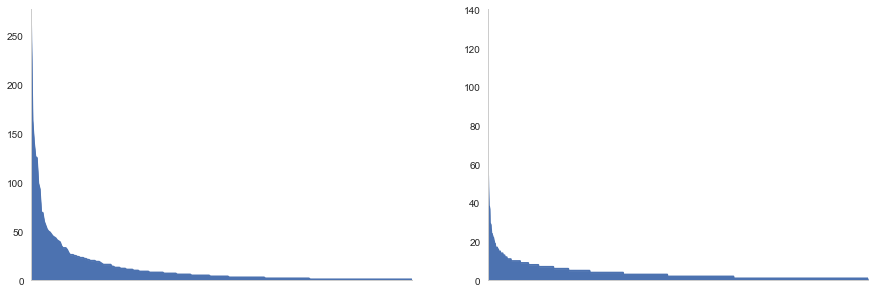

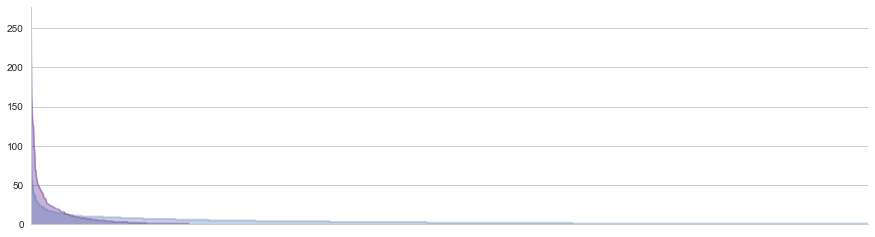

In [7]:
plt.figure(figsize=(15,5))
ax = plt.subplot(121)
df_train["Gene"].value_counts().plot("area")
plt.grid(False)
ax.get_xaxis().set_ticks([])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax = plt.subplot(122)
df_test["Gene"].value_counts().plot("area")
plt.grid(False)
ax.get_xaxis().set_ticks([])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.figure(figsize=(15,4))
ax = plt.subplot()
df_train["Gene"].value_counts().plot("area", alpha=0.33, color="#551a8b")
df_test["Gene"].value_counts().plot("area", alpha=0.33)
ax.get_xaxis().set_ticks([])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

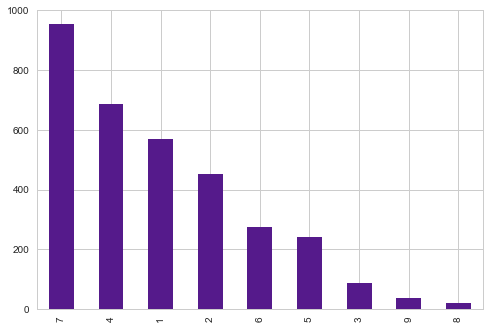

In [8]:
df_train["Class"].value_counts().plot(kind="bar", color = "#551a8b")

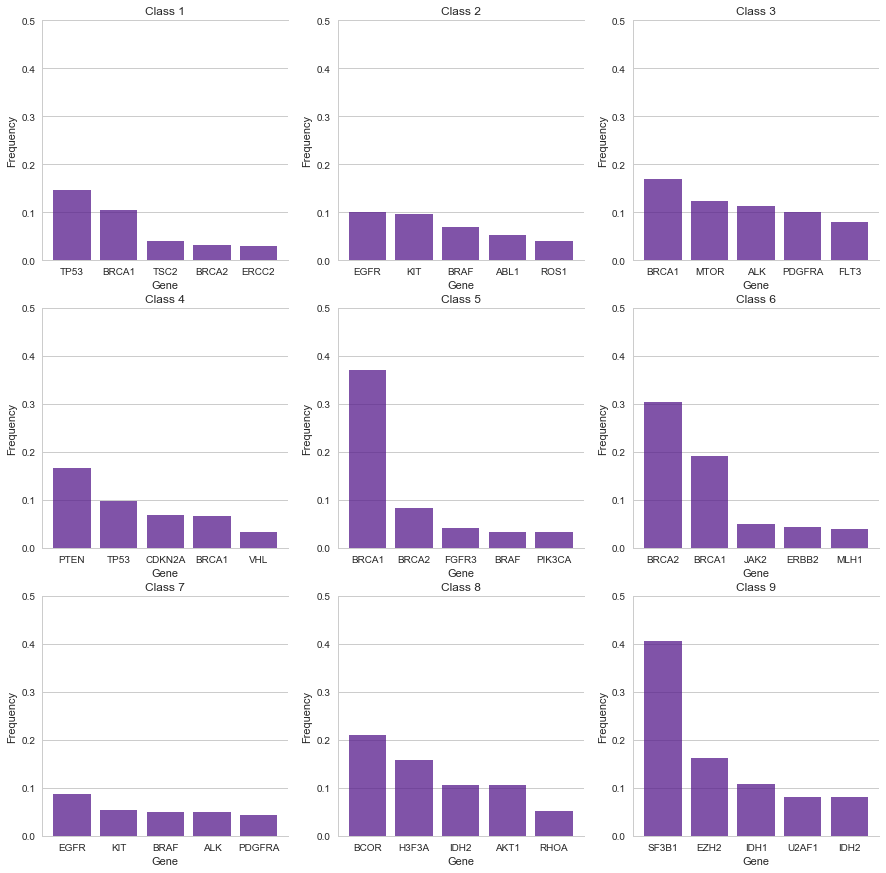

In [9]:
df_train_grouped = df_train.groupby("Class")

plt.figure(figsize = (15,15))
for i,group in enumerate(df_train_grouped):
    most_frequent = group[1]["Gene"].value_counts()[:5]
    total = group[1]["Gene"].value_counts().sum()
    fraction = most_frequent/total
    ax = plt.subplot(3,3,i+1)
    plt.title("Class {}".format(i+1))
    plt.xticks(range(5), group[1]["Gene"].value_counts()[:5].index)
    plt.xlabel("Gene")
    plt.ylabel("Frequency")
    plt.ylim(0, 0.5)
    plt.grid(axis='x')
    ax.spines["right"].set_visible(False)
    fig = plt.bar(range(5), most_frequent/total, color="#551a8b", alpha=0.75)

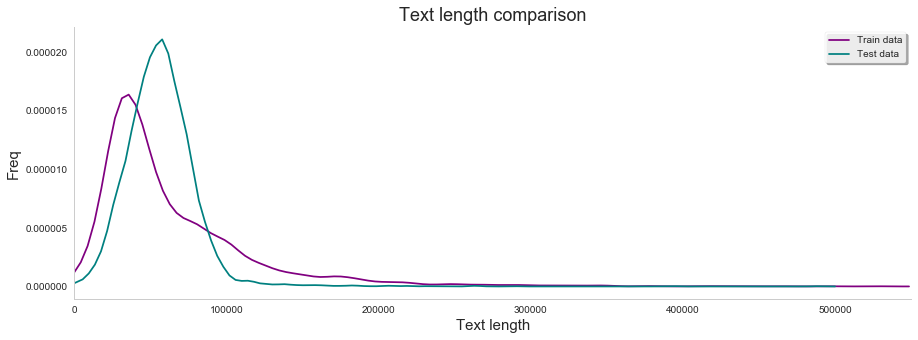

In [10]:
plt.figure(figsize(15,5))
ax = plt.subplot()
train_len = [len(i) for i in df_train["Text"]]
test_len = [len(i) for i in df_test["Text"]]
plt.xlim(0, 550000)
#plt.hist(train_len, color="purple", alpha=0.5, bins=100, label="Train data");
#plt.hist(test_len, color="teal", alpha=0.5, bins=100, label="Test data");
sns.distplot(train_len, hist=False, label="Train data", color="purple");
sns.distplot(test_len, hist=False, label="Test data", color="teal");
plt.legend(frameon=True, fancybox=True, shadow=True);
plt.grid(False);
ax.spines["top"].set_visible(False);
ax.spines["right"].set_visible(False);
plt.title("Text length comparison", fontsize=18);
plt.xlabel("Text length", fontsize=15);
plt.ylabel("Freq", fontsize=15);

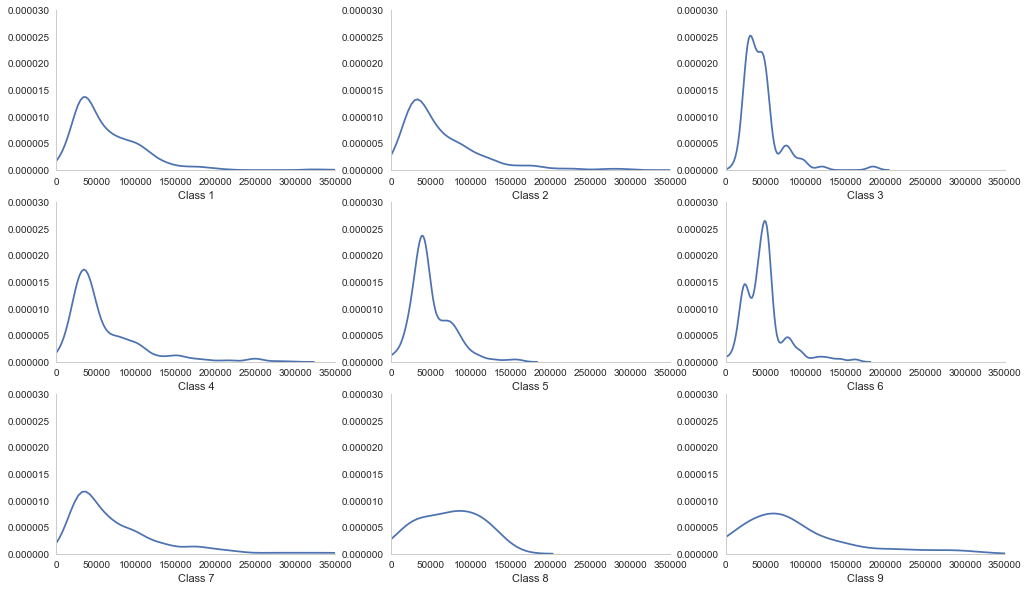

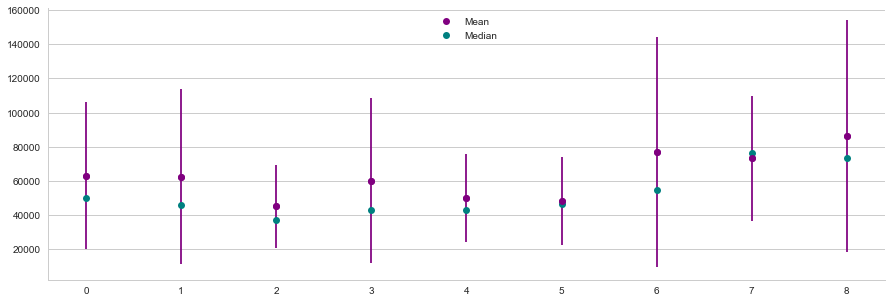

In [11]:
plt.figure(figsize=(17,10))
mean_text_length = []
median_text_length = []
std_text_length = []
for i, group in enumerate(df_train_grouped):
    ax = plt.subplot(3,3,i+1)
    plt.grid(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.xlim(0,350000)
    plt.ylim(0,0.00003)
    length = []
    for text in group[1]["Text"]:
        length.append(len(text))
    mean_text_length.append(np.mean(length))
    median_text_length.append(np.median(length))
    std_text_length.append(np.std(length))
    #plt.hist(length,bins=50,color="purple", alpha=0.66)
    sns.distplot(length, hist=False, axlabel="Class {}".format(i+1))
  
plt.figure()
ax = plt.subplot()
plt.plot(mean_text_length, 'o', color="purple", label="Mean")
ax.errorbar(range(9), mean_text_length, std_text_length, fmt='o', color="purple")
plt.plot(median_text_length,"o", color="teal", label="Median")
plt.legend(loc=9)
plt.grid(axis="x")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)


import nltk
nltk.download()


import textblob

txt = textblob.TextBlob(df_train["Text"][52]) 
x = txt.noun_phrases
y = txt.sentences

In [18]:
from nltk import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

ps = PorterStemmer()

words = "Here I remove stop words form the text. Those words are nltk corpus stopwords + some custom words. Afterwards the text corpus of the entry is truncated. Therefore, the text is searched for the mutation as well as the gene name. Afterwards the 250 character before and after the word are extracted and the text in saved in 'processe"
words = words.split(" ")

for w in words:
    w = ps.stem(w)

here
I
remov
stop
word
form
the
text.
those
word
are
nltk
corpu
stopword
+
some
custom
words.
afterward
the
text
corpu
of
the
entri
is
truncated.
therefore,
the
text
is
search
for
the
mutat
as
well
as
the
gene
name.
afterward
the
250
charact
befor
and
after
the
word
are
extract
and
the
text
in
save
in
'process


In [24]:
import textblob

txt = textblob.TextBlob(df_train["Text"][52])
txt.words

WordList(['Protein', 'tyrosine', 'phosphatase', 'Ï�', 'PTPÏ�', 'belongs', 'to', 'the', 'classical', 'receptor', 'type', 'IIB', 'family', 'of', 'protein', 'tyrosine', 'phosphatase', 'the', 'most', 'frequently', 'mutated', 'tyrosine', 'phosphatase', 'in', 'human', 'cancer', 'There', 'are', 'evidences', 'to', 'suggest', 'that', 'PTPÏ�', 'may', 'act', 'as', 'a', 'tumor', 'suppressor', 'gene', 'and', 'dysregulation', 'of', 'Tyr', 'phosphorylation', 'can', 'be', 'observed', 'in', 'diverse', 'diseases', 'such', 'as', 'diabetes', 'immune', 'deficiencies', 'and', 'cancer', 'PTPÏ�', 'variants', 'in', 'the', 'catalytic', 'domain', 'have', 'been', 'identified', 'in', 'cancer', 'tissues', 'These', 'natural', 'variants', 'are', 'nonsynonymous', 'single', 'nucleotide', 'polymorphisms', 'variations', 'of', 'a', 'single', 'nucleotide', 'occurring', 'in', 'the', 'coding', 'region', 'and', 'leading', 'to', 'amino', 'acid', 'substitutions', 'In', 'this', 'study', 'we', 'investigated', 'the', 'effect', 'of

## Preprocessing of the text
#### Here I remove stop words form the text. Those words are nltk corpus stopwords + some custom words. Afterwards the text corpus of the entry is truncated. Therefore, the text is searched for the mutation as well as the gene name. Afterwards the 250 character before and after the word are extracted and the text in saved in 'processed'.

In [27]:
def text_processing(df):
    import re
    from nltk import word_tokenize
    import textblob
    
    from nltk.corpus import stopwords
    stopWords = ["fig", "figure", "fig." "et", "al", "table",  
            "data", "analysis", "analyze", "study",  
            "method", "result", "conclusion", "author",  
            "find", "found", "show", "perform",  
            "demonstrate", "evaluate", "discuss", "google", "scholar",   
            "pubmed",  "web", "science", "crossref", "supplementary", 
            "(1)","(2)","(3)","(4)","(5)","(6)","(7)","(8)","(9)","(10)","(11)","(12)","(13)","(14)","(15)",
            "(1).","(2).","(3).","(4).","(5).","(6).","(7).","(8).","(9).","(10).","(11).","(12).","(13).","(14).","(15).",
            "(1)]","(2)]","(3)]","(4)]","(5)]","(6)]","(7)]","(8)]","(9)]","(10)]","(11)]","(12)]","(13)]","(14)]","(15)]",
            "(1)].","(2)].","(3)].","(4)].","(5)].","(6)].","(7)].","(8)].","(9)].","(10)].","(11)].","(12)].","(13)].","(14)].","(15)]."]
    
    stop = set(stopwords.words('english')+stopWords)

    processed = []
    for j, i in enumerate(df["Variation"]):
        trunc_text = (" ").join([i for i in df["Text"].iloc[j].lower().split() if i not in stop])
        if i == "Truncating Mutations":
            gene_name = df["Gene"].iloc[j].lower()
            pos_gene = [m.start() for m in re.finditer(gene_name, trunc_text)]
            pos_var = []
        else:
            gene_name = df["Gene"].iloc[j].lower()
            var_name = i.lower()
            pos_var = [m.start() for m in re.finditer(var_name, trunc_text)]
            pos_gene = [m.start() for m in re.finditer(gene_name, trunc_text)]       

        text = ""

        for i in pos_var:
                temp = ""
                temp = trunc_text[i-2000:i+2000]
                try:
                    while temp[0] != " ":
                        temp = temp[1:]
                    while temp[-1] != " ":
                        temp = temp[:-1]
                except:
                    pass
                text += temp.lstrip()

        for i in pos_gene:
                temp = ""
                temp = trunc_text[i-2000:i+2000]
                try:
                    while temp[0] != " ":
                        temp = temp[1:]
                    while temp[-1] != " ":
                        temp = temp[:-1]
                except:
                    pass
                text += temp.lstrip()

        processed.append(text)
    return processed

In [72]:
def text_processing(df):
    import re
    from nltk import word_tokenize
    import textblob
    
    from nltk.corpus import stopwords
    stopWords = ["fig", "figure", "fig." "et", "al", "table",  
            "data", "analysis", "analyze", "study",  
            "method", "result", "conclusion", "author",  
            "find", "found", "show", "perform",  
            "demonstrate", "evaluate", "discuss", "google", "scholar",   
            "pubmed",  "web", "science", "crossref", "supplementary", 
            "(1)","(2)","(3)","(4)","(5)","(6)","(7)","(8)","(9)","(10)","(11)","(12)","(13)","(14)","(15)",
            "(1).","(2).","(3).","(4).","(5).","(6).","(7).","(8).","(9).","(10).","(11).","(12).","(13).","(14).","(15).",
            "(1)]","(2)]","(3)]","(4)]","(5)]","(6)]","(7)]","(8)]","(9)]","(10)]","(11)]","(12)]","(13)]","(14)]","(15)]",
            "(1)].","(2)].","(3)].","(4)].","(5)].","(6)].","(7)].","(8)].","(9)].","(10)].","(11)].","(12)].","(13)].","(14)].","(15)]."]
    
    stop = set(stopwords.words('english')+stopWords)

    processed = []
    
    for j, i in enumerate(df["Variation"]):
        trunc_text = (" ").join([i for i in df["Text"].iloc[j].lower().split() if i not in stop])
        trunc_text = textblob.TextBlob(trunc_text)
        trunc_text = trunc_text.words
        trunc_text = [i for i in trunc_text if len(i) > 2]
        trunc_text = [i.singularize() for i in trunc_text]  
        trunc_text = (" ").join(trunc_text)
                      
        if i == "Truncating Mutations":
            gene_name = df["Gene"].iloc[j].lower()
            pos_gene = [m.start() for m in re.finditer(gene_name, trunc_text)]
            pos_var = []
        else:
            gene_name = df["Gene"].iloc[j].lower()
            var_name = i.lower()
            pos_var = [m.start() for m in re.finditer(var_name, trunc_text)]
            pos_gene = [m.start() for m in re.finditer(gene_name, trunc_text)]       

        text = ""

        for i in pos_var:
                temp = ""
                temp = trunc_text[i-2000:i+2000]
                try:
                    while temp[0] != " ":
                        temp = temp[1:]
                    while temp[-1] != " ":
                        temp = temp[:-1]
                except:
                    pass
                text += temp.lstrip()

        for i in pos_gene:
                temp = ""
                temp = trunc_text[i-2000:i+2000]
                try:
                    while temp[0] != " ":
                        temp = temp[1:]
                    while temp[-1] != " ":
                        temp = temp[:-1]
                except:
                    pass
                text += temp.lstrip()

        processed.append(text)
    return processed

In [73]:
df_train["processed_text"] = text_processing(df_train)
df_test["processed_text"] = text_processing(df_test)

In [74]:
df_train.to_csv("df_train_2009")
#df_test.to_csv("df_test_1909")

In [75]:
df_test1 = df_test.loc[:1000]
df_test2 = df_test.loc[1000:2000]
df_test3 = df_test.loc[2000:3000]
df_test4 = df_test.loc[3000:4000]
df_test5 = df_test.loc[4000:]

In [76]:
df_test1.to_csv("df_test1_2009")
df_test2.to_csv("df_test2_2009")
df_test3.to_csv("df_test3_2009")
df_test4.to_csv("df_test4_2009")
df_test5.to_csv("df_test5_2009")

X = []
y = []
for group in df_train_grouped:
    print(group[1])
    for ent in group[1]["Text"]:
        X.append(txt)
    for cls in group[1]["Class"]:
        y.append(cls)      


### Convert a collection of text documents to a matrix of token counts

In [81]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(df_train["processed_text"])
X_test_counts = count_vect.fit_transform(df_test["processed_text"])

###  reduce the weightage of more common words like (the, is, an etc.) which occurs in all document

In [82]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.fit_transform(X_test_counts)

In [84]:
def save_sparse_csr(filename,array):
    np.savez(filename,data = array.data ,indices=array.indices,
             indptr =array.indptr, shape=array.shape )

def load_sparse_csr(filename):
    loader = np.load(filename)
    return csr_matrix((loader['data'], loader['indices'], loader['indptr']), shape = loader['shape'])

In [85]:
save_sparse_csr("train_checkpoint", X_train_tfidf)
save_sparse_csr("test_checkpoint", X_test_tfidf)

In [7]:
X_train_tfidf = load_sparse_csr("train_checkpoint.npz")
X_test_tfidf = load_sparse_csr("test_checkpoint.npz")

In [86]:
from sklearn.model_selection import train_test_split

y = df_train["Class"]
y = y-1
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, y, test_size = 0.2, random_state=1337)

In [11]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(1660, 140196)
(1245, 140196)
(416, 140196)
(1660,)
(1245,)
(416,)


In [87]:
import lightgbm as lgb

d_train = lgb.Dataset(X_train, y_train)
d_val = lgb.Dataset(X_test, y_test, reference=d_train)


param = {'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 9,
    'metric': {'multi_logloss'},
    'learning_rate': 0.05, 
    'max_depth': 30,
    'num_iteration': 1000, 
    'num_leaves': 60, 
    'min_data_in_leaf': 90, 
    'feature_fraction': 0.75}

#rnds = 260
#mod = lgb.train(parms, train_set=d_train, num_boost_round=rnds,
#               valid_sets=[d_val], valid_names=['dval'], verbose_eval=20,
#               early_stopping_rounds=20)

num_round = 25
#bst = lgb.train(param, d_train, num_round, valid_sets=d_val, early_stopping_rounds=10)
#model = lgb.cv(param, d_train,num_round, nfold=5)

In [88]:
clf = lgb.train(param,d_train, num_boost_round=300)

C:\Users\Wegee\Anaconda3\lib\site-packages\lightgbm\engine.py:100: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [89]:
y_pred = clf.predict(X_test)

In [93]:
correct = 0
for j,i in enumerate(y_pred):
    if np.argmax(i) == list(y_test)[j]:
        correct += 1
print(correct/len(y_pred))

0.649624060150376


In [91]:
submission_prediction = clf.predict(X_test_tfidf)

In [92]:
with open("submission_lgb.csv", 'w') as x:
    x.write("ID,class1,class2,class3,class4,class5,class6,class7,class8,class9")
    x.write("\n")
    for i, prediction in enumerate(submission_prediction):
        t = [0,0,0,0,0,0,0,0,0,0]
        t[1:] = prediction
        t[0] = df_test.index[i]
        x.write(str(t).strip('[]'))
        x.write("\n")


In [53]:
correct = 0
for j,i in enumerate(y_pred):
    if np.argmax(i)+1 == list(y_test)[j]:
        correct += 1
print(correct/len(y_pred))

0.0321285140562249


In [52]:
y_test[0]

KeyError: 0

In [1]:
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_classes' : 9,
    'metric': {'l2', 'auc'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

print('Start training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=1,
                valid_sets=lgb_eval,
                early_stopping_rounds=20)

print('Start predicting...')
# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
# eval
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

print('Feature names:', gbm.feature_name())

# feature importances
print('Feature importances:', list(gbm.feature_importance()))
"""
parameters = { "colsample_bytree" : [0.6, 0.7, 0.8],
               "subsample":[0.6,0.8,1]}

xgbclassifier = xgboost.XGBClassifier(
    learning_rate=0.05, 
    n_estimators = 500,
    objective = 'binary:logistic',
    seed = 1337,
    silent = False)

clf = GridSearchCV(xgbclassifier, parameters, cv=5)
print("Aaaaaaaaaand here we go! :D")
clf.fit(X_train, y_train)
"""



NameError: name 'X_train' is not defined

In [ ]:
predicted = clf.predict(X_test)
np.mean(predicted == y_test)

In [ ]:
clf = xgboost.XGBClassifier(learning_rate=0.05, 
    n_estimators = 500,
    objective = 'binary:logistic',
    seed = 1337,
    silent = False,
    subsample = 0.8,
    colsample_bytree = 0.8,
    min_child_weight = 5)

clf.fit(X_train, y_train)

In [ ]:
print((X_test_tfidf.shape))
print(X_train_tfidf.shape)

for i in X_test_tfidf:
    print(i.shape)
    break

In [ ]:
print(df)

In [ ]:
print(len(submission_prediction))

In [ ]:
with open("submission_2.csv", 'w') as x:
    x.write("ID,class1,class2,class3,class4,class5,class6,class7,class8,class9")
    x.write("\n")
    for i, prediction in enumerate(submission_prediction):
        t = [0,0,0,0,0,0,0,0,0,0]
        t[1:] = prediction
        t[0] = df_test.index[i]
        x.write(str(t).strip('[]'))
        x.write("\n")


In [ ]:
from sklearn.model_selection import GridSearchCV
parameters = {"colsample_bylevel" : [0.6, 0.7, 0.8], 
               "colsample_bytree" : [0.6, 0.7, 0.8],
               "gamma":[0.001,0.01,0.1], 
               "max_depth":[5,10,15],
               "min_child_weight":[1,3,5], 
                
               
               "subsample":[0.6,0.8,1],}
xgbclassifier = XGBClassifier(
    learning_rate=0.05, 
    n_estimators = 500,
    objective = 'binary:logistic',
    seed = 1337,
    silent = False)

clf = GridSearchCV(xgbclassifier, parameters, cv=5)

clf.fit(X_train_tfidf, y_train)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
text_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', MultinomialNB()),])

text_clf = text_clf.fit(X_train, y_train)

In [ ]:
predicted = text_clf.predict(X_test)
np.mean(predicted == y_test)

In [ ]:
predicted = text_clf.predict(X_test)
np.mean(predicted == y_test)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
text_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                            alpha=1e-3, n_iter=5, random_state=1337))])

text_clf = text_clf.fit(X_train, y_train)
predicted = text_clf.predict(X_test)
np.mean(predicted == y_test)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
text_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', SGDClassifier(loss='modified_huber', penalty='elasticnet',
                                            alpha=1e-3, n_iter=5, random_state=1337))])

text_clf = text_clf.fit(X_train, y_train)
predicted = text_clf.predict(X_test)
np.mean(predicted == y_test)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_train_counts.shape

from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

In [ ]:
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
text_clf = Pipeline([('vect', CountVectorizer(stop_words='english')),
                      ('tfidf', TfidfTransformer()),
                      ('clf', XGBClassifier(objective='multi:softprob'))])

text_clf = text_clf.fit(X_train, y_train)
predicted = text_clf.predict(X_test)
np.mean(predicted == y_test)

In [ ]:
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
text_clf = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer())])

text_clf = text_clf.fit(X_train, y_train)
predicted = text_clf.predict(X_test)
np.mean(predicted == y_test)

In [ ]:
submission_prediction = text_clf.predict_proba(df_test["processed_text"])

In [ ]:
submission_prediction[0]

In [ ]:
submission_prediction[0]

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
text_clf = Pipeline([('vect', CountVectorizer(stop_words='english')),
                      ('tfidf', TfidfTransformer()),
                      ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                            alpha=1e-3, n_iter=5, random_state=1337))])

text_clf = text_clf.fit(X_train, y_train)
predicted = text_clf.predict(X_test)
np.mean(predicted == y_test)

In [ ]:
#for j,i in enumerate(word_count):
#    print("Group {}".format(j+1))
#    print(i[:20])
    
words = []
freq = []

for group in word_count:
    word_temp = []
    freq_temp = []
    word_temp = [i[0] for i in group]
    freq_temp = [i[1] for i in group]
    words.append(word_temp)
    freq.append(freq_temp)

percentages = []
for group in freq:
    percentages.append(group/sum(group))